In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/var/folders/gg/9f69dtmn6vjbk9_cmv3vx3lc0000gn/T/ipykernel_36337/2026785699.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [26]:
keys = ['cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 24)]

def df_preprocessing(list, col):
    temp = pd.DataFrame()
    for dataset in list:
        df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/'+dataset+'.txt', index_col=0, sep=" ", header=None)
        df.columns = keys
        df.dropna(axis=1, inplace=True)
        df.index.names = ['engine']
        df_col = df[['cycle', col]]
        df_col = df_col.reset_index()
        pivot = df_col.pivot(index='cycle', columns='engine', values=col)
        temp = pd.concat([temp, pivot], axis=1)
    temp.columns = range(temp.shape[1])
    temp.index = pd.to_datetime(temp.index, origin='2000-01-01', unit='D')
    for col in temp.columns:
        temp[col] = temp[col].shift(periods=temp[col].isna().sum(), fill_value=np.nan)    
    return temp

In [54]:
# train_df = df_preprocessing(['train_FD001', 'train_FD002', 'train_FD004'], 'sensor_14') # 609 trajectories 
# test_df = df_preprocessing(['test_FD001'], 'sensor_14') # 100 trajectories
# train_df

In [84]:
df = df_preprocessing(['train_FD001', 'train_FD002', 'train_FD004', 'test_FD001'], 'sensor_14') # 709 trajectories 
columns = df.columns.tolist()
np.random.shuffle(columns)

split_index = int(0.7 * len(columns))
train_df = df[columns[:split_index]]
test_df = df[columns[split_index:]]
df

,0,1,2,3,4,5,6,7,8,9,...,699,700,701,702,703,704,705,706,707,708
cycle,,,,,,,,,,,,,,,,,,,,,
2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-06-23,8117.69,8174.85,8238.86,8246.77,8203.89,8110.10,8146.81,8120.84,8266.83,8173.14,...,8131.03,8121.31,8154.11,8134.37,8136.10,8147.00,8145.88,8138.22,8160.62,8213.28
2001-06-24,8117.51,8166.83,8251.82,8241.99,8208.49,8110.79,8139.94,8117.88,8271.39,8177.31,...,8127.33,8122.26,8153.99,8137.49,8133.34,8154.61,8154.37,8144.02,8152.36,8210.85
2001-06-25,8112.58,8164.83,8249.86,8253.53,8206.86,8108.26,8149.60,8126.20,8272.83,8181.11,...,8128.73,8123.93,8155.46,8133.41,8127.15,8150.93,8153.28,8140.75,8148.20,8217.24


In [87]:
# convert df to training and testing datasets
prediction_length = 24

train_data = [{"start": df.index[0], "target": df[i].values[:-prediction_length]} for i in df.columns] # (128 - 24) by 100
test_data = [{"start": df.index[0], "target": df[i].values} for i in df.columns] # 128 by 100

# train_data = [{"start": train_df.index[0], "target": train_df[i].values} for i in train_df.columns]
# test_data = [{"start": test_df.index[0], "target": test_df[i].values} for i in test_df.columns]

train_ds = ListDataset(data_iter=train_data, freq='1D') # training dataset
test_ds = ListDataset(data_iter=test_data, freq='1D') # testing dataset

In [88]:
prediction_length = 24 # default
num_samples = 100 # default - for probability forecasting, try 10->100 this time
context_length = 32
device = "mps"

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=10e-4, # training params

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # }, 

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 25,}, # <- lightning trainer arguments
    )

In [89]:
# training the predictor

predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:14<00:00,  3.51it/s, v_num=28]

Epoch 0, global step 50: 'train_loss' reached 9.25212 (best 9.25212), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_28/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 26/? [00:07<00:00,  3.49it/s, v_num=28]

In [68]:
from gluonts.dataset.split import split
window_length = predictor.prediction_length + predictor.lead_time
_, test_template = split(test_data, offset=-window_length)
result = test_template.generate_instances(window_length)

TestData(dataset=[{'start': Period('2000-01-02', 'D'), 'target': array([    nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan, 

In [64]:
# inference on test datasets using the fine-tuned predictor

forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,
        predictor=predictor,
        num_samples=num_samples)
# inference time: 13min
# why does the inference time sometimes take up to 13 min ans sometimes only an instant???

In [65]:
forecasts = list(forecast_it)
tss = list(ts_it)

# forecasts = list(tqdm(forecast_it, total=len(test_ds)+len(train_ds), desc="Forecasting batches"))
# tss = list(tqdm(ts_it, total=len(test_ds)+len(train_ds), desc="Ground truth"))

# also why does list() take so long? what does it do?
# v_num=27 took 15min for this block

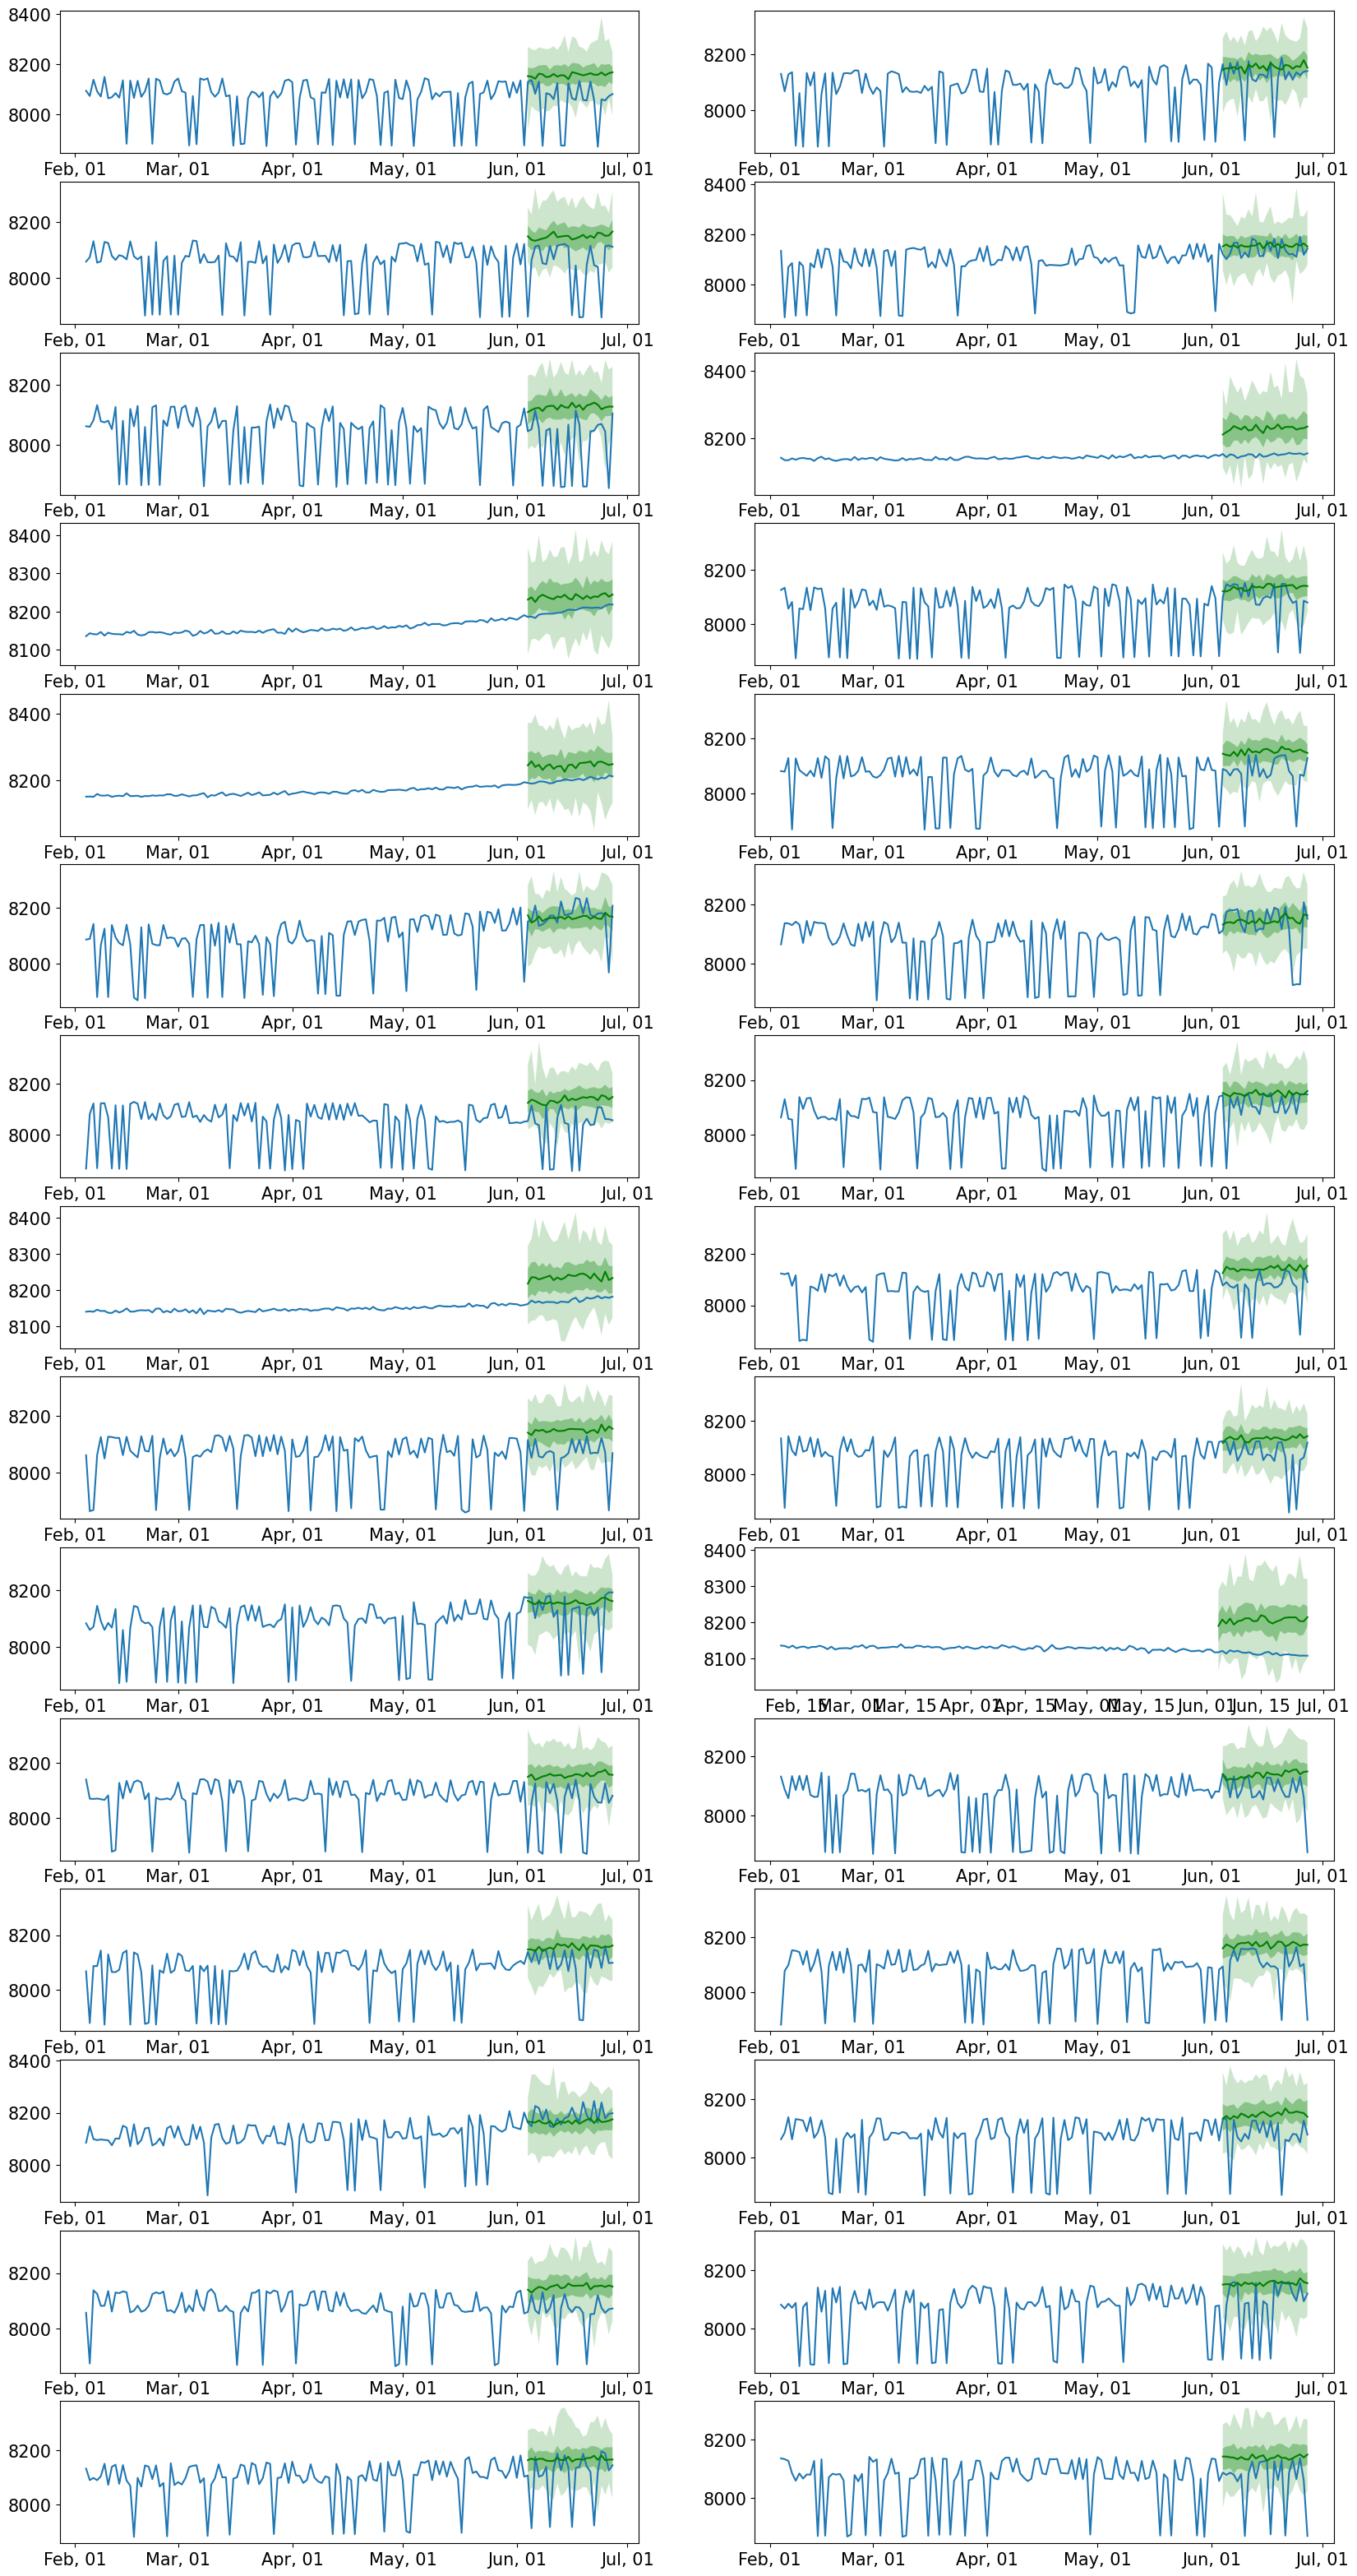

In [66]:
plt.figure(figsize=(20, 40))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples 
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 30):
    ax = plt.subplot(15, 2, idx+1)

    plt.plot(ts[-6 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks()
    ax.xaxis.set_major_formatter(date_formater)

In [67]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss']) 
# CRPS: 0.0031304983256903937 for aligning at the end and trimming the beginning
# CRPS: 0.003155105264314208 for aligning at the end and leaving NaN at the beginning
# CRPS: 0.00494559862857452 for sampling 100 times at inference time
# CRPS: 0.0026430073758037954 for splitting the datasets 70%/30%
# CRPS: 0.007216525143117412 for having 609 trajectories as training datasets (Train_FD001, Train_FD002, Train_FD004)
# and 100 trajectories as testing datasets (Test_FD002)
# CRPS: 0.007270284629327364 for having 709 (609+100) trajectories and a train/test split of (70%, 30%)

'''
Why is the fine-tuning result still quite bad (large deviation in value & fail to capture trends )? how to improve?
- Too few training samples (70 trajctories only), 
- 
'''

Running evaluation: 213it [00:00, 3793.83it/s]
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up seria

CRPS: 0.007270284629327364


'\nWhy is the fine-tuning result still quite bad (large deviation in value & fail to capture trends )? how to improve?\n- Too few training samples (70 trajctories only), \n- \n'